In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from numpy.random import exponential
from numpy.random import poisson
from rl.chapter9.order_book import *
from rl.distribution import Distribution
from rl.markov_process import MarkovProcess, NonTerminal

#### Modelling Order Book Dynamics with coupled OU processes

Here we play around with using [Ornstein-Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) processes to simulate the mean-reverting behavior of bid / ask prices in an order book.

Over a time step $\Delta t$, the dynamics of the current bid price $P_t^{(a)}$ are modeled by

$$
\Delta P_t^{(a)} = \kappa \cdot \bigg( \frac{\bar{P}_t}{P_t^{(a)}} - (1 + |\eta| \cdot \mathbf{1}_{P_t^{(a)} < P_t^{(b)}}) \bigg) + \sigma \cdot (1 \wedge \kappa) \cdot \xi
$$

where

* $\kappa$ = $|P_t^{(a)} - P_t^{(b)}| / K$ is called the "stack degree", which attempts to capture the tendency for bid / ask prices to snap back towards eachother the further away they are because market makers want to fill in the gap.  Here we set $K = 10$.

* $\bar{P}_t$ is the midpoint between the current bid and ask price.  This is the value to which these prices revert.

* $\eta \sim \mathcal{N}(0, 1)$ models the quickness at which the market corrects itself after crossing.

* $1 \wedge \kappa$ is used to decrease the variance of the stochastic component of the walk when the bid / ask prices are very close to eachother, that is, when $\kappa < 1$

* $\xi \sim \mathcal{N}(0, 1)$



The dynamics of the current ask price $P_t^{(b)}$ are modeled analogously.


#### Limit Orders

The argument `limit_order_block` specifies the number of limit orders to be added to each side of the market.  At each timestep, we draw a sequence of random variables of the form 

$$
P_t^{(a)} + \chi(\kappa \cdot K)
$$
$$
P_t^{(b)} - \chi(\kappa \cdot K)
$$

These are added as limit orders to the market.

where $\chi(\alpha) \sim \exp(\alpha)$

#### Market Orders

The argument `market_order_block` governs the distribution of market order occurrences.

At each time-step, if the bid price decreases, then with probability $p = \frac{|\Delta P_t^{(b)}|}{1 + |\Delta P_t^{(b)}|}$, we add a sell market order with amount $s \sim \text{Poiss}(\lambda)$, where $\lambda =$`market_order_block`.  This attempts to capture the "scare effect" in which sharp decreases in the bid price lead to a selling cascade.

Likewise, if the ask price increases, then the probability of a buy market order is modeled analogously to capture the "buying craze" effect.

In [2]:
@dataclass(frozen=True)
class OrderBookState(NonTerminal):
    """Wrapper class storing OrderBook as a Nonterminal State."""
    state: OrderBook


@dataclass
class OrderBook_Walk(Distribution[OrderBook]):
    """Class modeling random walks of bid/ask prices as OU processes."""

    curr_ob: OrderBook

    sigma: float

    limit_order_block: int
    market_order_block: int

    def sample_OU(self, curr_bid: float, curr_ask: float) -> Tuple[float, float]:
        sigma = self.sigma
        stack_degree: float = np.abs(curr_ask - curr_bid)
        midpoint: float = (curr_ask + curr_bid) / 2
        del_bid: float = (
            stack_degree
            * (
                midpoint
                - curr_bid
                - curr_bid * np.abs(np.random.randn()) * (curr_ask < curr_bid)
            )
            / (curr_bid * 10)
            + sigma * np.minimum(stack_degree, 1) * np.random.randn()
        )
        del_ask: float = (
            stack_degree
            * (
                midpoint
                - curr_ask
                + curr_ask * np.abs(np.random.randn()) * (curr_ask < curr_bid)
            )
            / (curr_ask * 10)
            + sigma * np.minimum(stack_degree, 1) * np.random.randn()
        )

        return del_bid, del_ask

    def sample(self) -> OrderBookState:
        del_bid, del_ask = self.sample_OU(
            self.curr_ob.bid_price(), self.curr_ob.ask_price()
        )

        new_bid = self.curr_ob.bid_price() + del_bid
        new_ask = self.curr_ob.ask_price() + del_ask

        ob = self.curr_ob

        for _ in range(self.limit_order_block):

            ob = ob.buy_limit_order(
                int(new_bid - exponential(np.abs(new_bid - new_ask))), 1
            )[1]
            ob = ob.sell_limit_order(
                int(new_ask + exponential(np.abs(new_bid - new_ask))), 1
            )[1]

        bid_spinner = np.random.random()
        ask_spinner = np.random.random()

        if del_bid < 0 and bid_spinner > 1 / (1 + np.abs(del_bid)):
            ob = ob.sell_market_order(poisson(self.market_order_block))[1]
        if del_ask > 0 and ask_spinner > 1 / (1 + np.abs(del_ask)):
            ob = ob.buy_market_order(poisson(self.market_order_block))[1]

        return OrderBookState(ob)

    def expectation() -> None:
        raise NotImplementedError()


In [3]:
bids: PriceSizePairs = [
    DollarsAndShares(dollars=x, shares=poisson(100.0 - (100 - x) * 10))
    for x in range(100, 90, -1)
]
asks: PriceSizePairs = [
    DollarsAndShares(dollars=x, shares=poisson(100.0 - (x - 105) * 10))
    for x in range(105, 115, 1)
]
ob0: OrderBook = OrderBook(descending_bids=bids, ascending_asks=asks)


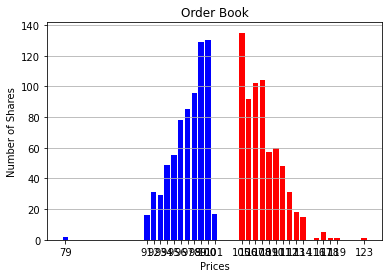

In [4]:
obw = OrderBook_Walk(curr_ob=ob0, sigma= 2.5, limit_order_block=100, market_order_block=200)
obw.sample().state.display_order_book()

In [5]:
@dataclass
class OrderBookMarkovProcess(MarkovProcess):

    init_ob_walk: OrderBook_Walk
    #init_ob_state : init_ob_walk

    def transition(self, state: OrderBookState):
        return OrderBook_Walk(
            curr_ob=state.state,
            sigma=self.init_ob_walk.sigma,
            limit_order_block=self.init_ob_walk.limit_order_block,
            market_order_block=self.init_ob_walk.market_order_block,
        )


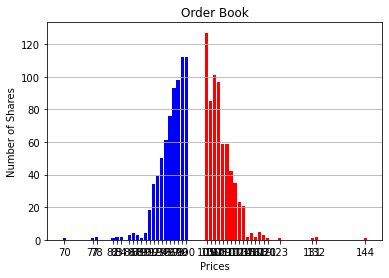

In [6]:
obmp = OrderBookMarkovProcess(init_ob_walk=obw)

N_sims = 10

for ob in obmp.simulate(obw):
    if N_sims == 10:
        break
ob.state.display_order_book()
    

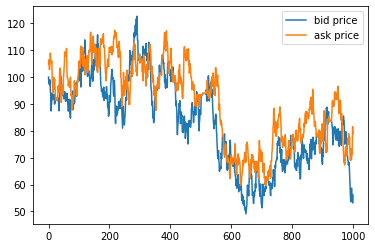

In [7]:
obw = OrderBook_Walk(curr_ob=ob0, sigma= 2.5, limit_order_block=100, market_order_block=200)
N_sims = 1000


curr_bid = ob0.bid_price()
curr_ask = ob0.ask_price()

bids = []
asks = []



for _ in range(N_sims):
    bids.append(curr_bid)
    asks.append(curr_ask)
    
    (del_bid, del_ask) = obw.sample_OU(curr_ask=curr_ask, curr_bid=curr_bid)
    curr_bid += del_bid
    curr_ask += del_ask

plt.plot(bids, label = "bid price")
plt.plot(asks, label = "ask price")
plt.legend()
